### Imports

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Normal, kl_divergence
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from tqdm.auto import tqdm
import copy
import pickle
import gzip
import gdown
import os
from google.colab import drive

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# drive.mount('/content/drive')
# logdir = '/content/drive/MyDrive/Uncertainty in Deep Learning/Mini Project/Experiments'

## Models and Experiments

### Data

In [ ]:
class PermutedMNIST:
  def __init__(self, num_tasks=10, batch_size=256):
    super().__init__()
    path = 'mnist.pkl.gz'
    if not os.path.exists(path):
      file_id = '159W5BVgLAjv2T07RaQ2iMTJDQZoqQ_Mx'
      url = f'https://drive.google.com/uc?id={file_id}'
      data = gdown.download(url, quiet=True)

    with gzip.open(path, 'rb') as f:
      train, valid, test = pickle.load(f, encoding='latin1')


    train_data = torch.from_numpy(np.vstack((train[0], valid[0])))
    train_targets = torch.from_numpy(np.hstack((train[1], valid[1])))

    test_data, test_targets = torch.from_numpy(test[0]), torch.from_numpy(test[1])


    self.train_data = TensorDataset(train_data.to(torch.float32), train_targets.to(torch.long))
    self.test_data = TensorDataset(test_data.to(torch.float32), test_targets.to(torch.long))

    self.num_tasks = num_tasks
    self.batch_size = batch_size
    self.current_task = 0

  def next_task(self):
    assert self.current_task < self.num_tasks, "Maximum number of tasks completed."
    if self.current_task > 0:
      torch.manual_seed(self.current_task)
      permutation = torch.randperm(784)
      train_data = TensorDataset(self.train_data.tensors[0][:, permutation], self.train_data.tensors[1])
      test_data = TensorDataset(self.test_data.tensors[0][:, permutation], self.test_data.tensors[1])
    else:
      train_data, test_data = self.train_data, self.test_data

    train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

    self.current_task += 1
    return train_loader, test_loader


In [ ]:
class SplitMNIST:
  def __init__(self, num_tasks=5, tasks=((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)), batch_size=256):
    super().__init__()
    path = 'mnist.pkl.gz'
    if not os.path.exists(path):
      file_id = '159W5BVgLAjv2T07RaQ2iMTJDQZoqQ_Mx'
      url = f'https://drive.google.com/uc?id={file_id}'
      data = gdown.download(url, quiet=True)

    with gzip.open(path, 'rb') as f:
      train, valid, test = pickle.load(f, encoding='latin1')

    self.train_data = torch.from_numpy(np.vstack((train[0], valid[0])))
    self.train_targets = torch.from_numpy(np.hstack((train[1], valid[1])))

    self.test_data, self.test_targets = torch.from_numpy(test[0]), torch.from_numpy(test[1])

    self.num_tasks = num_tasks
    self.tasks = tasks
    self.batch_size = batch_size
    self.current_task = 0

  def next_task(self):
    assert self.current_task < self.num_tasks, "Maximum number of tasks completed"
    train_indices_0 = torch.where(
        self.train_targets == self.tasks[self.current_task][0],
    )[0]
    train_indices_1 = torch.where(
        self.train_targets == self.tasks[self.current_task][1],
    )[0]
    test_indices_0 = torch.where(
        self.test_targets == self.tasks[self.current_task][0],
    )[0]
    test_indices_1 = torch.where(
        self.test_targets == self.tasks[self.current_task][1],
    )[0]

    train_targets_0 = torch.zeros(train_indices_0.size(0), dtype=torch.float32)
    train_targets_1 = torch.ones(train_indices_1.size(0), dtype=torch.float32)

    test_targets_0 = torch.zeros(test_indices_0.size(0), dtype=torch.float32)
    test_targets_1 = torch.ones(test_indices_1.size(0), dtype=torch.float32)

    train_data = torch.cat((self.train_data[train_indices_0], self.train_data[train_indices_1]), dim=0).to(torch.float32)
    test_data = torch.cat((self.test_data[test_indices_0], self.test_data[test_indices_1]), dim=0).to(torch.float32)

    train_targets = torch.cat((train_targets_0, train_targets_1), dim=0)
    test_targets = torch.cat((test_targets_0, test_targets_1), dim=0)

    train_data = TensorDataset(train_data, train_targets)
    test_data = TensorDataset(test_data, test_targets)

    train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

    self.current_task += 1
    return train_loader, test_loader

In [ ]:
def random_coreset_permuted(loader, coreset_size):
  batch_size = loader.batch_size
  batch_coreset_size = coreset_size // len(loader)
  final_coreset_size = coreset_size % len(loader)

  num_samples = loader.dataset.tensors[0].size(0)
  data_size = loader.dataset.tensors[0].size(1)
  target_dtype = loader.dataset.tensors[1].dtype

  data_coreset = torch.zeros(size=(coreset_size, data_size), dtype=torch.float32)
  targets_coreset = torch.zeros(size=(coreset_size,), dtype=target_dtype)

  data_ = []
  targets_ = []
  coreset_index = 0
  for idx, (data, target) in enumerate(loader):
    sz = min(batch_coreset_size if idx < len(loader) - 1 else final_coreset_size, data.size(0))
    permutation = torch.randperm(data.size(0))
    selection_indices = permutation[:sz]
    remaining_indices = permutation[sz:]

    cs_data = data[selection_indices]
    cs_target = target[selection_indices]
    data_.append(data[remaining_indices])
    targets_.append(target[remaining_indices])

    data_coreset[coreset_index:coreset_index + sz] = cs_data
    targets_coreset[coreset_index:coreset_index + sz] = cs_target
    coreset_index += sz

  coreset_dataset = TensorDataset(data_coreset, targets_coreset)
  coreset_loader = DataLoader(coreset_dataset, batch_size=batch_size, shuffle=True)

  data_, targets_ = torch.cat(data_, dim=0), torch.cat(targets_, dim=0)
  augmented_dataset = TensorDataset(data_, targets_.to(target_dtype))
  augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

  return coreset_loader, augmented_loader



def merge_loaders(loaders):
  coreset_data = []
  coreset_targets = []
  batch_size = loaders[0].batch_size
  data_dtype = loaders[0].dataset.tensors[0].dtype
  target_dtype = loaders[0].dataset.tensors[1].dtype

  for loader in loaders:
    data, targets = loader.dataset.tensors
    data, targets = data.detach(), targets.detach()
    coreset_data.append(data)
    coreset_targets.append(targets)

  coreset_data = torch.cat(coreset_data, dim=0)
  coreset_targets = torch.cat(coreset_targets, dim=0)

  merged_dataset = TensorDataset(coreset_data.to(data_dtype), coreset_targets.to(target_dtype))
  merged_loader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)
  return merged_loader

### Models

In [ ]:
class VanillaNN(nn.Module):
  def __init__(self, input_dim=784, hidden_dims=[100, 100], output_dim=10):
    super(VanillaNN, self).__init__()
    self.layers = nn.ModuleList()
    prev_dim = input_dim
    for hidden_dim in hidden_dims:
      self.layers.append(nn.Linear(prev_dim, hidden_dim))
      prev_dim = hidden_dim
    self.output = nn.Linear(prev_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    for layer in self.layers:
      x = self.relu(layer(x))
    x = self.output(x)
    return x

  def get_weights(self):
    weight_dict = {}
    for i, layer in enumerate(self.layers):
      weight_dict[f'W_{i}'] = layer.weight.data.detach().clone()
      weight_dict[f'b_{i}'] = layer.bias.data.detach().clone()
    weight_dict[f'W_out'] = self.output.weight.data.detach().clone()
    weight_dict[f'b_out'] = self.output.bias.data.detach().clone()
    return weight_dict


In [ ]:
class BayesianLinear(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(BayesianLinear, self).__init__()

    self.W_mu = nn.Parameter(torch.Tensor(size=(output_dim, input_dim)))
    self.W_logvar = nn.Parameter(torch.Tensor(size=(output_dim, input_dim)))
    self.b_mu = nn.Parameter(torch.Tensor(size=(output_dim,)))
    self.b_logvar = nn.Parameter(torch.Tensor(size=(output_dim,)))
    self._reset_parameters()

    self.register_buffer('W_mu_prior', torch.zeros_like(self.W_mu))
    self.register_buffer('W_logvar_prior', torch.zeros_like(self.W_logvar))
    self.register_buffer('b_mu_prior', torch.zeros_like(self.b_mu))
    self.register_buffer('b_logvar_prior', torch.zeros_like(self.b_logvar))

  def forward(self, x):
    W_var = torch.exp(self.W_logvar)
    b_var = torch.exp(self.b_logvar)

    mu_act = F.linear(x, self.W_mu, self.b_mu)
    var_act = F.linear(x ** 2, W_var, b_var)
    eps = torch.randn_like(mu_act)

    return mu_act + torch.sqrt(var_act) * eps

  def update_priors(self, prior_dict=None):
    if prior_dict is not None:
      self.W_mu_prior.data.copy_(prior_dict['W_mu_prior'])
      self.W_logvar_prior.data.copy_(prior_dict['W_logvar_prior'])

      self.b_mu_prior.data.copy_(prior_dict['b_mu_prior'])
      self.b_logvar_prior.data.copy_(prior_dict['b_logvar_prior'])
    else:
      self.W_mu_prior.data.copy_(self.W_mu.data)
      self.W_logvar_prior.data.copy_(self.W_logvar.data)

      self.b_mu_prior.data.copy_(self.b_mu.data)
      self.b_logvar_prior.data.copy_(self.b_logvar.data)

  def _reset_parameters(self):
    self.W_mu.data.normal_(0, 0.1)
    self.W_logvar.data.fill_(-6)

    self.b_mu.data.normal_(0, 0.1)
    self.b_logvar.data.fill_(-6)

  def kl_loss(self):
    W_var = torch.exp(self.W_logvar)
    W_var_prior = torch.exp(self.W_logvar_prior)

    b_var = torch.exp(self.b_logvar)
    b_var_prior = torch.exp(self.b_logvar_prior)

    kl_W = 0.5 * (torch.log((W_var_prior / W_var)) + (W_var / W_var_prior) + \
                  ((self.W_mu - self.W_mu_prior) ** 2 / W_var_prior) - 1).sum()
    kl_b = 0.5 * (torch.log((b_var_prior / b_var)) + (b_var / b_var_prior) + \
                  ((self.b_mu - self.b_mu_prior) ** 2 / b_var_prior) - 1).sum()

    return kl_W + kl_b

  def wasserstein_loss_1(self):
    W_sigma = torch.exp(0.5 * self.W_logvar)
    W_sigma_prior = torch.exp(0.5 * self.W_logvar_prior)

    b_sigma = torch.exp(0.5 * self.b_logvar)
    b_sigma_prior = torch.exp(0.5 * self.b_logvar_prior)

    wasserstein_W = torch.abs(self.W_mu - self.W_mu_prior).sum() + torch.abs(W_sigma - W_sigma_prior).sum()
    wasserstein_b = torch.abs(self.b_mu - self.b_mu_prior).sum() + torch.abs(b_sigma - b_sigma_prior).sum()

    return wasserstein_W + wasserstein_b

  def wasserstein_loss_2(self):
    W_sigma = torch.exp(0.5 * self.W_logvar)
    W_sigma_prior = torch.exp(0.5 * self.W_logvar_prior)

    b_sigma = torch.exp(0.5 * self.b_logvar)
    b_sigma_prior = torch.exp(0.5 * self.b_logvar_prior)

    wasserstein_W = (self.W_mu - self.W_mu_prior).pow(2).sum() + (W_sigma - W_sigma_prior).pow(2).sum()
    wasserstein_b = (self.b_mu - self.b_mu_prior).pow(2).sum() + (b_sigma - b_sigma_prior).pow(2).sum()

    return wasserstein_W + wasserstein_b

  def initialise_weights(self, W_mu, b_mu):
    self.W_mu_prior.data.copy_(W_mu)
    self.b_mu_prior.data.copy_(b_mu)

    # self.W_mu.data = W_mu.detach().clone()
    # self.b_mu.data = b_mu.detach().clone()


In [ ]:
class BayesianNet(nn.Module):
  def __init__(self, input_dim=784, hidden_dims=[100, 100], output_dim=10, single_head=True, num_tasks=10):
    super(BayesianNet, self).__init__()
    self.single_head = single_head
    self.num_tasks = num_tasks
    self.layers = nn.ModuleList()
    self.output_dim = output_dim
    prev_dim = input_dim
    for hidden_dim in hidden_dims:
      self.layers.append(BayesianLinear(prev_dim, hidden_dim))
      prev_dim = hidden_dim
    self.output = BayesianLinear(prev_dim, output_dim) if single_head else \
      nn.ModuleList([BayesianLinear(prev_dim, output_dim) for _ in range(num_tasks)])
    self.relu = nn.ReLU()

  def forward(self, x, task_num=None):
    for layer in self.layers:
      x = self.relu(layer(x))
    x = self.output(x) if self.single_head else self.output[task_num](x)
    return x

  def kl_loss(self):
    kl_div = 0.
    for layer in self.layers:
      kl_div += layer.kl_loss()
    kl_div += self.output.kl_loss() if self.single_head else sum([output.kl_loss() for output in self.output])
    return kl_div

  def wasserstein_loss_1(self):
    wasserstein_div = 0.
    for layer in self.layers:
      wasserstein_div += layer.wasserstein_loss_1()
    wasserstein_div += self.output.wasserstein_loss_1() if self.single_head else sum([output.wasserstein_loss_1() for output in self.output])
    return wasserstein_div

  def wasserstein_loss_2(self):
    wasserstein_div = 0.
    for layer in self.layers:
      wasserstein_div += layer.wasserstein_loss_2()
    wasserstein_div += self.output.wasserstein_loss_2() if self.single_head else sum([output.wasserstein_loss_2() for output in self.output])
    return wasserstein_div

  def update_priors(self, task):
    for layer in self.layers:
      layer.update_priors()
    if self.single_head:
      self.output.update_priors()
    else:
      self.output[task].update_priors()
      # if self.num_tasks > 1 and task < self.num_tasks - 1:
      #   prior_dict = {
      #       'W_mu_prior': self.output[task].W_mu.data.detach().clone(),
      #       'W_logvar_prior': self.output[task].W_logvar.data.detach().clone(),
      #       'b_mu_prior': self.output[task].b_mu.data.detach().clone(),
      #       'b_logvar_prior': self.output[task].b_logvar.data.detach().clone()
      #     }
      #   self.output[task + 1].update_priors(prior_dict)

  def initialise_layers(self, weight_dict):
    for i, layer in enumerate(self.layers):
      layer.initialise_weights(weight_dict[f'W_{i}'], weight_dict[f'b_{i}'])
    if self.single_head:
      self.output.initialise_weights(weight_dict[f'W_out'], weight_dict[f'b_out'])
    else:
      self.output[0].initialise_weights(weight_dict[f'W_out'], weight_dict[f'b_out'])
      # if self.num_tasks > 1:
      #   self.output[1].initialise_weights(weight_dict[f'W_out'], weight_dict[f'b_out'])


### Classification Metrics

In [ ]:
def bayesian_loss(model, data, target, task_num, single_head, loss_mode, reg='kl', lambd=0.1, num_samples=30):
  nll_loss = 0.
  if loss_mode == 'classification':
    nll_fn = nn.CrossEntropyLoss(reduction='mean')
  elif loss_mode == 'binary_classification':
    nll_fn = nn.BCEWithLogitsLoss(reduction='mean')
  else:
    nll_fn = nn.MSELoss(reduction='mean')
  for _ in range(num_samples):
    pred = model(data) if single_head else model(data, task_num)
    nll_loss += nll_fn(pred, target)

  nll_loss /= num_samples
  if reg == 'ws_1':
    reg_loss = model.wasserstein_loss_1()
  elif reg == 'ws_2':
    reg_loss = model.wasserstein_loss_2()
  else:
    reg_loss = model.kl_loss()
  reg_loss /= data.size(0)
  return nll_loss + lambd * reg_loss

In [ ]:
def compute_accuracy(model, data, target, task_num, single_head, loss_mode='classification', num_samples=10):
  model.eval()
  with torch.no_grad():
    if single_head:
      output = torch.stack([model(data) for _ in range(num_samples)], dim=0)
    else:
      output = torch.stack([model(data, task_num) for _ in range(num_samples)], dim=0)
    output = torch.mean(output, dim=0)
    if loss_mode == 'binary_classification':
      predicted = (torch.sigmoid(output) > 0.5).float()
      predicted = predicted.view(-1)
      target = target.view(-1)
    else:
      predicted = torch.argmax(output, dim=-1)
    return (predicted == target).float().mean().item()

### Training/Testing Functions

In [ ]:
def train_vanilla(model, optimiser, train_loader, loss_mode='classification', num_epochs=50):
  if loss_mode == 'classification':
    nll_fn = nn.CrossEntropyLoss(reduction='mean')
  elif loss_mode == 'binary_classification':
    nll_fn = nn.BCEWithLogitsLoss(reduction='mean')
  else:
    nll_fn = nn.MSELoss(reduction='mean')
  for epoch in range(num_epochs):
    model.train()
    for _, (data, target) in enumerate(train_loader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      optimiser.zero_grad()
      pred = model(data)
      if loss_mode == 'binary_classification':
        target = target.unsqueeze(dim=-1)
      if loss_mode == 'regression':
        target = F.one_hot(target.to(torch.long), num_classes=model.output_dim).to(torch.float32)
      loss = nll_fn(pred, target)
      loss.backward()
      optimiser.step()

def eval_vanilla(model, test_loader):
  model.eval()
  test_accuracy = 0.
  with torch.no_grad():
    for _, (data, target) in enumerate(test_loader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      test_accuracy += model(data).argmax(dim=-1).eq(target).float().mean().item()
  return test_accuracy / len(test_loader)


def train_bayesian(model, optimiser, train_loader, task_num, single_head, loss_mode='classification', reg='kl', num_epochs=50, lambd=0.5, num_samples=30):
  for epoch in range(num_epochs):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      if loss_mode == 'binary_classification':
        target = target.unsqueeze(dim=-1)
      if loss_mode == 'regression':
        target = F.one_hot(target.to(torch.long), num_classes=model.output_dim).to(torch.float32)
      optimiser.zero_grad()
      loss = bayesian_loss(model, data, target, task_num, single_head, loss_mode=loss_mode, reg=reg, lambd=lambd, num_samples=num_samples)
      loss.backward()
      optimiser.step()

def eval_bayesian(model, test_loader, task_num, single_head, loss_mode, num_samples=30):
  model.eval()
  test_accuracy = 0.
  with torch.no_grad():
    for idx, (data, target) in enumerate(test_loader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      test_accuracy += compute_accuracy(model, data, target, task_num, single_head, loss_mode=loss_mode, num_samples=num_samples)
  return test_accuracy / len(test_loader)

def regression_loss(model, test_loader, task_num, single_head, loss_mode, num_samples=30):
  model.eval()
  test_loss = 0.
  with torch.no_grad():
    for idx, (data, target) in enumerate(test_loader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      if single_head:
        output = torch.stack([model(data) for _ in range(num_samples)], dim=0)
      else:
        output = torch.stack([model(data, task_num) for _ in range(num_samples)], dim=0)
      output = torch.mean(output, dim=0)
      num_classes = output.size(1)
      target = F.one_hot(target.to(torch.long), num_classes=num_classes).to(torch.float32)
      test_loss += torch.sqrt(F.mse_loss(output, target)).item()
  return test_loss / len(test_loader)


# def eval_tasks(model, test_loader, single_head, num_samples=5, is_bayesian=True):
#   # test_accuracies = []
#   # for i, test_loader in enumerate(test_loaders):
#   if is_bayesian:
#    return eval_bayesian(model, test_loader, task_num=i, single_head=single_head, num_samples=num_samples)
#   else:
#     return eval_vanilla(model, test_loader)
#   # return np.mean(test_accuracies)

In [ ]:
def vcl(generator=PermutedMNIST, num_tasks=10, single_head=True, num_epochs=30, lambd=[1e-3], num_samples=5, \
                        lr=1e-3, loss_mode='classification', reg='kl', batch_size=256, \
                        update_priors=True, input_dim=784, hidden_dims=[100, 100], output_dim=10, \
                        coreset_size=0, use_vanilla=False, verbose=True, plot_output=True):

  accuracy_matrix = np.zeros((2*num_tasks, num_tasks)) if loss_mode == 'regression' else np.zeros((num_tasks, num_tasks))
  generator = generator(num_tasks=num_tasks, batch_size=batch_size)
  train_loaders, test_loaders = [], []
  coreset_loaders = []
  accuracies = []

  model_bayesian = BayesianNet(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, \
                      single_head=single_head, num_tasks=num_tasks).to(DEVICE)
  optimiser_bayesian = torch.optim.Adam(model_bayesian.parameters(), lr=lr)

  if use_vanilla:
    model_vanilla = VanillaNN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim).to(DEVICE)
    optimiser_vanilla = torch.optim.Adam(model_vanilla.parameters(), lr=lr)
    train_loader, test_loader = generator.next_task()
    train_loaders.append(train_loader)
    test_loaders.append(test_loader)
    train_vanilla(model_vanilla, optimiser_vanilla, train_loader, loss_mode=loss_mode, num_epochs=num_epochs)
    model_bayesian.initialise_layers(model_vanilla.get_weights())

  for task in tqdm(range(num_tasks)):
    if task == 0 and use_vanilla:
      train_loader, test_loader = train_loaders[0], test_loaders[0]
    else:
      train_loader, test_loader = generator.next_task()
    if coreset_size > 0:
      coreset_loader, train_loader = random_coreset_permuted(train_loader, coreset_size)
      coreset_loaders.append(coreset_loader)
      if task > 0 and single_head:
        train_loader = merge_loaders([train_loader, coreset_loaders[task - 1]])

    train_loaders.append(train_loader)
    test_loaders.append(test_loader)

    print(f'Task {task + 1} / {num_tasks}')
    train_loader, test_loader = train_loaders[task], test_loaders[task]
    train_bayesian(model_bayesian, optimiser_bayesian, train_loader, task_num=task, single_head=single_head, \
                     loss_mode=loss_mode, reg=reg, num_epochs=num_epochs, lambd=lambd[task], num_samples=num_samples)
    if update_priors:
      model_bayesian.update_priors(task)
    # inference_model = BayesianNet(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, \
    #                   single_head=single_head, num_tasks=num_tasks).to(DEVICE)
    # inference_model.load_state_dict(model_bayesian.state_dict())
    # inference_optimiser = torch.optim.Adam(inference_model.parameters(), lr=lr)

    if coreset_size > 0:
      if single_head:
        merged_coreset = merge_loaders(coreset_loaders) if task > 0 else coreset_loaders[0]
        train_bayesian(model_bayesian, optimiser_bayesian, merged_coreset, task_num=task, single_head=single_head, \
                        loss_mode=loss_mode, reg=reg, num_epochs=num_epochs, lambd=lambd[task], num_samples=num_samples)
      else:
        train_bayesian(model_bayesian, optimiser_bayesian, coreset_loaders[task], task_num=task, single_head=single_head, \
                        loss_mode=loss_mode, reg=reg, num_epochs=num_epochs, lambd=lambd[task], num_samples=num_samples)

    for i in range(task + 1):
      accuracy_matrix[task, i] = eval_bayesian(model_bayesian, test_loaders[i], i, single_head=single_head, loss_mode=loss_mode, num_samples=num_samples)
      if loss_mode == 'regression':
        accuracy_matrix[num_tasks + task, i] = regression_loss(model_bayesian, test_loaders[i], i, single_head=single_head, loss_mode=loss_mode, num_samples=num_samples)
    accuracies.append(np.mean(accuracy_matrix[task, :task+1]))

    if verbose:
      print(f'Accuracies at task {task + 1} = {accuracy_matrix[task, :]}')
      print(f'Average accuracy at task {task + 1} = {accuracies[-1]}')
      print('\n')


  if plot_output:
    fig, ax = plt.subplots(figsize=(10, 5))
    _ = ax.plot(range(1, num_tasks + 1), accuracies, marker='o', label=f'Coreset Size = {coreset_size}')
    _ = ax.set_xlabel('Task')
    _ = ax.set_ylabel('Accuracy')
    _ = ax.set_title('Accuracy vs Number of Tasks')
    _ = ax.legend()
    plt.show()

  return accuracy_matrix, accuracies, model_bayesian

### Experiments

#### Permuted MNIST Baseline

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
KL_LAMBDA = [0. for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 0
USE_VANILLA = False
LR = 1e-4
UPDATE_PRIORS = False

accuracy_matrix_baseline, avg_accuracies_baseline, model_baseline = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           batch_size=BATCH_SIZE, update_priors=UPDATE_PRIORS, num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, \
                                           num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True)

np.save(os.path.join(logdir, 'accuracy_matrix_permuted_baseline'), accuracy_matrix_baseline)

#### Permuted MNIST (Without Coresets)

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
KL_LAMBDA = [2e-2 for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 0
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-4

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

#### Permuted MNIST (With Coresets)

##### Coreset Size = 200

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
KL_LAMBDA = [2e-2 for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 200
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-4

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

# np.save(os.path.join(logdir, f'accuracy_matrix_permuted_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

##### Coreset Size = 400

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
KL_LAMBDA = [2e-2 for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 400
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-4

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

##### Coreset Size = 1000

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
KL_LAMBDA = [2e-2 for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 1000
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-4

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=True, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

#### Split MNIST (Baseline)

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 0
UPDATE_PRIORS = False
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_baseline'), accuracy_matrix_split)

#### Split MNIST (VCL - No Coreset)

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [1e-1 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 0
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

#### SplitMNIST (VCL - Coresets)

##### Coreset Size = 200

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [1e-1 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 200
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

##### Coreset Size = 400

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [1e-1 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 400
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

##### Coreset Size 1000

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [1e-1 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 1000
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

#### Regression Experiments

##### Baseline

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 256
LAMBD = [0. for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 0
USE_VANILLA = False
LR = 1e-4
UPDATE_PRIORS = False
OUTPUT_DIM = 10

accuracy_matrix_baseline, avg_accuracies_baseline, model_baseline = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           batch_size=BATCH_SIZE, update_priors=UPDATE_PRIORS, num_epochs=NUM_EPOCHS, lambd=LAMBD, \
                                           num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True, output_dim=OUTPUT_DIM)

np.save(os.path.join(logdir, 'accuracy_matrix_permuted_regression_baseline'), accuracy_matrix_baseline)

##### Permuted MNIST (Without Coresets)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 256
KL_LAMBDA = [0.0] + [1e-4 for _ in range(NUM_TASKS)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 0
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 3e-4
OUTPUT_DIM = 10

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True, output_dim=OUTPUT_DIM)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

##### Permuted MNIST (With Coresets)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 256
KL_LAMBDA = [0.0] + [1e-4 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 200
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 3e-4
OUTPUT_DIM = 10

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True, output_dim=OUTPUT_DIM)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 256
KL_LAMBDA = [0.0] + [1e-4 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 400
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 3e-4
OUTPUT_DIM = 10

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True, output_dim=OUTPUT_DIM)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 256
KL_LAMBDA = [0.0] + [1e-4 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 1000
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 3e-4
OUTPUT_DIM = 10

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True, output_dim=OUTPUT_DIM)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

##### Split MNIST (Baseline)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0 for _ in range(NUM_TASKS)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 0
UPDATE_PRIORS = False
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=2)

np.save(os.path.join(logdir, f'accuracy_matrix_split_regression_baseline'), accuracy_matrix_split)

##### Split MNIST (VCL - No Coresets)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 0
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=2)

np.save(os.path.join(logdir, f'accuracy_matrix_split_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

##### Split MNIST (VCL - Coresets)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 200
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=2)

np.save(os.path.join(logdir, f'accuracy_matrix_split_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 400
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=2)

np.save(os.path.join(logdir, f'accuracy_matrix_split_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

In [ ]:
NLL_TYPE = 'regression'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 25
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 1000
UPDATE_PRIORS = True
LR = 3e-4

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, \
                                           coreset_size=CORESET_SIZE, use_vanilla=False, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=2)

np.save(os.path.join(logdir, f'accuracy_matrix_split_regression_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

#### Wasserstein Loss Experiments

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 256
LAMBD = [0.0] + [5.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 0
REG = 'ws_2'
USE_VANILLA = True
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=LAMBD, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 256
LAMBD = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 200
REG = 'ws_2'
USE_VANILLA = True
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=LAMBD, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 256
LAMBD = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 400
REG = 'ws_2'
USE_VANILLA = True
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=LAMBD, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

In [ ]:
NLL_TYPE = 'classification'
GENERATOR = PermutedMNIST
NUM_TASKS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 256
LAMBD = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = True
NUM_SAMPLES = 10
CORESET_SIZE = 1000
REG = 'ws_2'
USE_VANILLA = True
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_permuted, avg_accuracies_permuted, model_permuted = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=LAMBD, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, update_priors=UPDATE_PRIORS, plot_output=True)

np.save(os.path.join(logdir, f'accuracy_matrix_permuted_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_permuted)

##### Split MNIST

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 5
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 0
REG = 'ws_2'
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 5
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 200
REG = 'ws_2'
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 5
KL_LAMBDA = [0.0] + [1.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 400
REG = 'ws_2'
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

In [ ]:
NLL_TYPE = 'binary_classification'
GENERATOR = SplitMNIST
NUM_TASKS = 5
NUM_EPOCHS = 5
KL_LAMBDA = [0.0] + [2.0 for _ in range(NUM_TASKS - 1)]
SINGLE_HEAD = False
NUM_SAMPLES = 10
CORESET_SIZE = 1000
REG = 'ws_2'
USE_VANILLA = False
UPDATE_PRIORS = True
LR = 1e-3

accuracy_matrix_split, avg_accuracies_split, model_split = vcl(generator=GENERATOR, num_tasks=NUM_TASKS, single_head=SINGLE_HEAD, \
                                           num_epochs=NUM_EPOCHS, lambd=KL_LAMBDA, num_samples=NUM_SAMPLES, lr=LR, loss_mode=NLL_TYPE, reg=REG, \
                                           coreset_size=CORESET_SIZE, use_vanilla=USE_VANILLA, plot_output=True, update_priors=UPDATE_PRIORS, output_dim=1)

np.save(os.path.join(logdir, f'accuracy_matrix_split_reg_{REG}_vcl_coreset_{CORESET_SIZE}'), accuracy_matrix_split)

## Results

In [2]:
path = 'Experiments'
if not os.path.exists(path):
  file_id = '1BgOfdQQYw0_TTjHZeZ8VOkkDtzr_LZES'
  url = f'https://drive.google.com/drive/folders/1BgOfdQQYw0_TTjHZeZ8VOkkDtzr_LZES?usp=sharing'
  data = gdown.download_folder(url, quiet=True)


accuracy_matrices = {}
for file in os.listdir(path):
  if file.endswith('.npy'):
    accuracy_matrices[file] = np.load(os.path.join(path, file))

In [3]:
def cl_metrics(task_matrix):
  num_tasks = task_matrix.shape[0]
  avg_accuracy = np.mean(task_matrix[-1, :])
  BWT = np.mean([task_matrix[-1, i] - task_matrix[i, i] for i in range(num_tasks - 1)])
  FM = np.mean([np.max(task_matrix[i+1:, i]) - task_matrix[-1, i] for i in range(num_tasks - 1)])
  task_accuracies = [np.mean(task_matrix[i, :i+1]) for i in range(num_tasks)]

  return task_accuracies, avg_accuracy, BWT, FM


def plot_accuracies(accuracies, experiment_name):
  accuracy_baseline = accuracies[0]
  accuracy_vcl_0 = accuracies[1]
  accuracy_vcl_200 = accuracies[2]
  accuracy_vcl_400 = accuracies[3]
  accuracy_vcl_1000 = accuracies[4]

  T = len(accuracy_baseline)

  textwidth_in_pt = 455.24411
  pt_to_inch = 1.0 / 72.27

  width_in = 0.6 * textwidth_in_pt * pt_to_inch
  line_height_pt = 12
  height_in = 3.5 * line_height_pt * pt_to_inch

  fig, ax = plt.subplots(figsize=(8, 4))
  ax.set_title(experiment_name)
  ax.set_xlabel('Task')
  ax.set_ylabel('Accuracy')
  ax.plot(range(1, T+1), accuracy_baseline, marker='o', label='Baseline')
  ax.plot(range(1, T+1), accuracy_vcl_0, marker='o', label='VCL - No Coresets')
  ax.plot(range(1, T+1), accuracy_vcl_200, marker='o', label='VCL - Coreset Size 200')
  ax.plot(range(1, T+1), accuracy_vcl_400, marker='o', label='VCL - Coreset Size 400')
  ax.plot(range(1, T+1), accuracy_vcl_1000, marker='o', label='VCL - Coreset Size 1000')
  ax.legend()
  plt.tight_layout()
  plt.show()
  plt.savefig(f"{experiment_name}_accuracies.png")

def plot_metrics(metrics, experiment_name):
  metrics_baseline = metrics[0]
  metrics_vcl_0 = metrics[1]
  metrics_vcl_200 = metrics[2]
  metrics_vcl_400 = metrics[3]
  metrics_vcl_1000 = metrics[4]

  x = np.arange(3)
  width = 0.2
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width*2.5, metrics_baseline, width, label='Baseline')
  rects2 = ax.bar(x - width/2, metrics_vcl_0, width, label='VCL - No Coresets')
  rects3 = ax.bar(x + width/2, metrics_vcl_200, width, label='VCL - Coreset Size 200')
  rects4 = ax.bar(x + width*2.5, metrics_vcl_400, width, label='VCL - Coreset Size 400')
  rects5 = ax.bar(x + width*5, metrics_vcl_1000, width, label='VCL - Coreset Size 1000')
  ax.set_ylabel('Metric')
  ax.set_title(experiment_name)
  ax.set_xticks(x)
  ax.set_xticklabels(['Avg Accuracy', 'BWT', 'FM'])
  ax.legend()
  plt.tight_layout()
  plt.show()
  plt.savefig(f"{experiment_name}_metrics.png")

In [14]:
def plot_combined_accuracies(accuracies, accuracies_regression, accuracies_ws2, permuted=True):
  accuracy_baseline = accuracies[0]
  accuracy_vcl_0 = accuracies[1]
  accuracy_vcl_200 = accuracies[2]
  accuracy_vcl_400 = accuracies[3]
  accuracy_vcl_1000 = accuracies[4]

  accuracy_baseline_reg = accuracies_regression[0]
  accuracy_vcl_0_reg = accuracies_regression[1]
  accuracy_vcl_200_reg = accuracies_regression[2]
  accuracy_vcl_400_reg = accuracies_regression[3]
  accuracy_vcl_1000_reg = accuracies_regression[4]

  accuracy_vcl_0_ws2 = accuracies_ws2[0]
  accuracy_vcl_200_ws2 = accuracies_ws2[1]
  accuracy_vcl_400_ws2 = accuracies_ws2[2]
  accuracy_vcl_1000_ws2 = accuracies_ws2[3]

  T = len(accuracy_baseline)
  exp = 'Permuted' if permuted else 'Split'

  fig, ax = plt.subplots(figsize=(8, 5))
  ax.set_title(f'{exp} MNIST')
  ax.set_xlabel('Task')
  ax.set_ylabel('Accuracy')
  ax.plot(range(1, T+1), accuracy_baseline, marker='o', label='Baseline')
  ax.plot(range(1, T+1), accuracy_vcl_0, marker='o', label=f'VCL - No Coresets')
  ax.plot(range(1, T+1), accuracy_vcl_200, marker='o', label=f'VCL - Coreset Size 200')
  ax.plot(range(1, T+1), accuracy_vcl_400, marker='o', label=f'VCL - Coreset Size 400')
  ax.plot(range(1, T+1), accuracy_vcl_1000, marker='o', label=f'VCL - Coreset Size 1000')

  ax.plot(range(1, T+1), accuracy_vcl_0_reg, marker='x', label=f'Regression VCL')
  ax.plot(range(1, T+1), accuracy_vcl_200_reg, marker='x', label=f'Regression VCL - 200')
  ax.plot(range(1, T+1), accuracy_vcl_400_reg, marker='x', label=f'Regression VCL - 400')
  ax.plot(range(1, T+1), accuracy_vcl_1000_reg, marker='x', label=f'Regression VCL - 1000')

  ax.plot(range(1, T+1), accuracy_vcl_0_ws2, marker='^', label=f'WS VCL')
  ax.plot(range(1, T+1), accuracy_vcl_200_ws2, marker='^', label=f'WS VCL - 200')
  ax.plot(range(1, T+1), accuracy_vcl_400_ws2, marker='^', label=f'WS VCL - 400')
  ax.plot(range(1, T+1), accuracy_vcl_1000_ws2, marker='^', label=f'WS VCL - 1000')

  ax.legend(loc='lower left')
  plt.tight_layout()
  plt.show()
  fig.savefig(f"{exp}_accuracies.png")



### Permuted

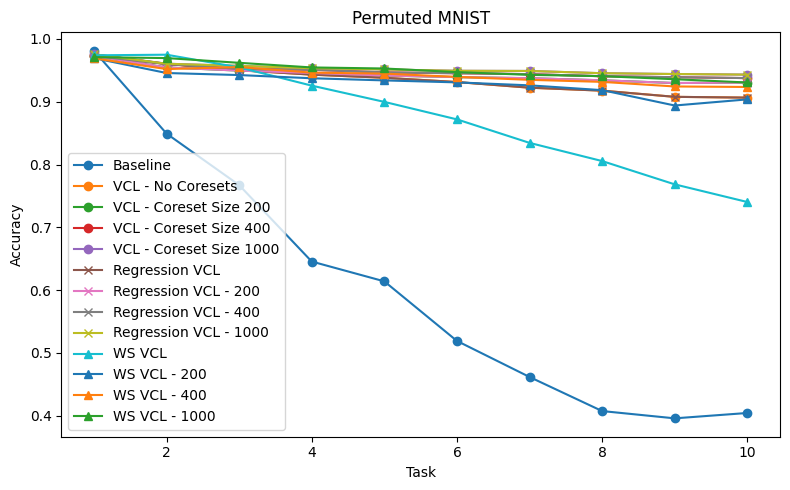

Accuracy VCL = 0.943
Accuracy VCL Regression = 0.943
Accuracy VCL Wasserstein = 0.931


In [17]:
exp = 'accuracy_matrix_permuted'
matrices_perm = [accuracy_matrices[exp + '_baseline.npy'], accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]

metrics_perm = [cl_metrics(M) for M in matrices_perm]
accuracies_perm = [m[0] for m in metrics_perm]
AA_perm = metrics_perm[-1][1]
BWT_perm = metrics_perm[-1][2]
FM_perm = metrics_perm[-1][3]

exp = 'accuracy_matrix_permuted_regression'
matrices_perm_reg = [accuracy_matrices[exp + '_baseline.npy'], accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]



metrics_perm_regression = [cl_metrics(M) for M in matrices_perm]
accuracies_perm_regression = [m[0] for m in metrics_perm_regression]
AA_perm_regression = metrics_perm_regression[-1][1]
BWT_perm_regression = metrics_perm_regression[-1][2]
FM_perm_regression = metrics_perm_regression[-1][3]

exp = 'accuracy_matrix_permuted_reg_ws_2'
matrices_perm_ws_2 = [accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]

metrics_perm_ws_2 = [cl_metrics(M) for M in matrices_perm_ws_2]
accuracies_perm_ws_2 = [m[0] for m in metrics_perm_ws_2]
AA_perm_ws_2 = metrics_perm_ws_2[-1][1]
BWT_perm_ws_2 = metrics_perm_ws_2[-1][2]
FM_perm_ws_2 =  metrics_perm_ws_2[-1][3]


AA_list = [AA_perm, AA_perm_regression, AA_perm_ws_2]
BWT_list = [BWT_perm, BWT_perm_regression, BWT_perm_ws_2]
FM_list = [FM_perm, FM_perm_regression, FM_perm_ws_2]

plot_combined_accuracies(accuracies_perm, accuracies_perm_regression, accuracies_perm_ws_2, permuted=True)

print(f'Accuracy VCL = {AA_perm:.3f}')
print(f'Accuracy VCL Regression = {AA_perm_regression:.3f}')
print(f'Accuracy VCL Wasserstein = {AA_perm_ws_2:.3f}')


### Split

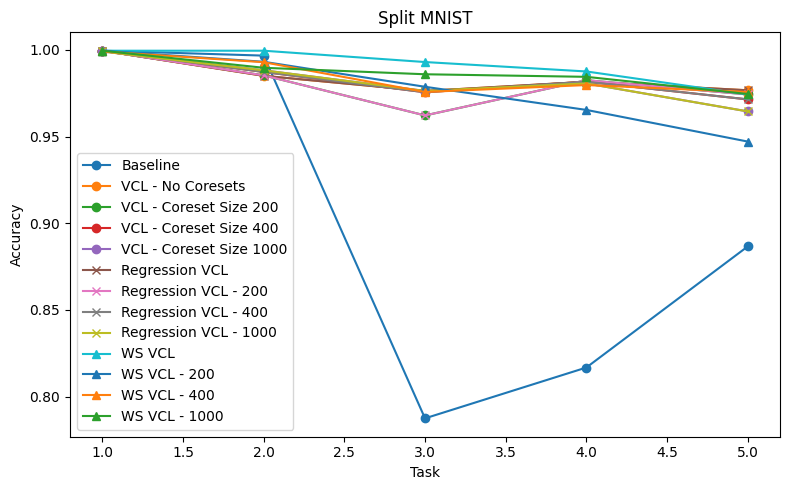

Accuracy VCL = 0.965
Accuracy VCL Regression = 0.965
Accuracy VCL Wasserstein = 0.975


In [22]:
exp = 'accuracy_matrix_split'
matrices_perm = [accuracy_matrices[exp + '_baseline.npy'], accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]

metrics_perm = [cl_metrics(M) for M in matrices_perm]
accuracies_perm = [m[0] for m in metrics_perm]
AA_perm = metrics_perm[-1][1]
BWT_perm = metrics_perm[-1][2]
FM_perm = metrics_perm[-1][3]

exp = 'accuracy_matrix_split_regression'
matrices_perm_reg = [accuracy_matrices[exp + '_baseline.npy'], accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]



metrics_perm_regression = [cl_metrics(M) for M in matrices_perm]
accuracies_perm_regression = [m[0] for m in metrics_perm_regression]
AA_perm_regression = metrics_perm_regression[-1][1]
BWT_perm_regression = metrics_perm_regression[-1][2]
FM_perm_regression = metrics_perm_regression[-1][3]

exp = 'accuracy_matrix_split_reg_ws_2'
matrices_perm_ws_2 = [accuracy_matrices[exp + '_vcl_coreset_0.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_200.npy'], accuracy_matrices[exp + '_vcl_coreset_400.npy'], \
                                 accuracy_matrices[exp + '_vcl_coreset_1000.npy']]

metrics_perm_ws_2 = [cl_metrics(M) for M in matrices_perm_ws_2]
accuracies_perm_ws_2 = [m[0] for m in metrics_perm_ws_2]
AA_perm_ws_2 = metrics_perm_ws_2[-1][1]
BWT_perm_ws_2 = metrics_perm_ws_2[-1][2]
FM_perm_ws_2 =  metrics_perm_ws_2[-1][3]


AA_list = [AA_perm, AA_perm_regression, AA_perm_ws_2]
BWT_list = [BWT_perm, BWT_perm_regression, BWT_perm_ws_2]
FM_list = [FM_perm, FM_perm_regression, FM_perm_ws_2]

plot_combined_accuracies(accuracies_perm, accuracies_perm_regression, accuracies_perm_ws_2, permuted=False)

print(f'Accuracy VCL = {AA_perm:.3f}')
print(f'Accuracy VCL Regression = {AA_perm_regression:.3f}')
print(f'Accuracy VCL Wasserstein = {AA_perm_ws_2:.3f}')
